In [2]:
# All imports
import urllib.request as ul
from bs4 import BeautifulSoup
import requests
import re
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
#---

senatorwiki = 'https://en.wikipedia.org/wiki/List_of_current_United_States_Senators'
html = requests.get(senatorwiki)
soup = BeautifulSoup(html.text)
senatortable = soup.find('table',{'class':"sortable"})
rows = senatortable.findAll('tr')

state, name, party, age, occupation, prev, assoff, termup, res = [], [], [], [], [], [], [], [], []

for tr in rows:
    cells=tr.findAll('td')
    alt = tr.findAll('th')
    if len(cells)==9:
        #state.append(cells[0].find(text=True))
        party.append(cells[2].find(text=True))
        occupation.append(cells[4].find(text=True))
        prev.append(cells[5].find(text=True))
        assoff.append(cells[6].find(text=True))
        termup.append(cells[7].find(text=True))
        res.append(cells[8].find(text=True))
        age.append(int(cells[3].find('span','noprint ForceAgeToShow').string[6:-1]))
    if len(cells)==10:
        state.append(cells[0].find(text=True))
        party.append(cells[3].find(text=True))
        occupation.append(cells[5].find(text=True))
        prev.append(cells[6].find(text=True))
        assoff.append(cells[7].find(text=True))
        termup.append(cells[8].find(text=True))
        res.append(cells[9].find(text=True))
        age.append(int(cells[4].find('span','noprint ForceAgeToShow').string[6:-1]))
    if len(alt)==1:
        name.append(alt[0].find(text=True))

stac = [el.find(text=True) for el in rows[0].findAll('th')]
cats = [el.rstrip() for el in stac]
cats.remove('Image')
cats[3] = 'Age'
zcat = dict(zip([str(x) for x in range(len(cats))],cats))

assoff = [x.rstrip() for x in assoff]
assoff = [datetime.datetime.strptime(x,'%B %d, %Y') for x in assoff]
occupation = [x.rstrip() for x in occupation]
termup = [x.rstrip() for x in termup]
termup = [datetime.datetime.strptime(x,'%Y') for x in termup]
states = [x for x in state for i in range(2)]
prev = [x.rstrip() for x in prev]

senators = pd.DataFrame([states,name,party,age,occupation,prev,assoff,termup,res],index=cats).T

today = datetime.date.today()
yrs = pd.Series([senators['Assumed office'][x].year for x in range(len(senators))])

senators['Years served'] = today.year - yrs

#takes the url tails for each senator
url = 'https://justfacts.votesmart.org/candidate/public-statements'
search = 'https://votesmart.org/search?q='
asen ='https://votesmart.org/officials/NA/C/-congressional?chamber=U'
html = requests.get(asen)
soup = BeautifulSoup(html.text)
f = soup.find('h5').find('a')['href'][10:]
soup.findAll('h5')
sencodedict = {line.text:line.find('a')['href'][10:] for line in soup.findAll('h5')}

#updates names to match votesmart
seniority = pd.Series([1 if x%2 else 0 for x in range(1,101)])
senators['Seniority'] = seniority
names = senators['Senator']
surnames = [name.split(' ')[-1] if name.split(' ')[-1] != 'Jr.' else name.split(' ')[-2] for name in names]
senators['Surname'] = surnames
senators = senators.sort_values(by='Surname')

# Alphabetized from votesmart.
sendict = list(sencodedict.keys())
rep = list(sencodedict.keys())
for x in range(len(rep)):
    rep[x] = rep[x].split(' ')
rep = sorted(rep,key=lambda x: x[-1] if (x[-1] != 'Jr.') and (x[-1] != 'III') else x[-2])
for x in range(len(rep)):
    rep[x] = ' '.join(rep[x])
    
senators['Senator'] = rep

alphalist = list(senators['Senator'])
femwiki = 'https://en.wikipedia.org/wiki/Women_in_the_United_States_Senate'
femhtml = requests.get(femwiki)
chickensoup = BeautifulSoup(femhtml.text)
femtable = chickensoup.find('table',{'class':"sortable"})
frows = femtable.findAll('tr')
ttxt = []
for line in femtable.findAll('a'):
    ttxt.append(line.text)
femlist = [x for x in alphalist if x.split(' ')[-1] in [x.split(' ')[-1] for x in ttxt]]
gender = [1 if x not in femlist else 0 for x in alphalist]
senators['Gender'] = gender

party = {}
party[senators['Party'].unique()[0]] = 1
party[senators['Party'].unique()[1]] = -1
party[senators['Party'].unique()[2]] = 0
party_list = [party[x] for x in senators['Party']]
senators['Partynum'] = party_list

# analysis groups
posgrp = ['noun','verb','adj','adv','intj','pron','wh','conj','prep']
lengthgrp = ['short word', 'long word', 'short sent', 'long sent']
humorgrp = ['glb humor', 'glb humor M', 'glb humor F', 'glb humor young', 'glb humor old']
emot_all = ['joy', 'fear', 'sadness', 'anticipation', 'anger', 'disgust', 'trust', 'surprise']
emot_glb = ['glb '+x for x in emot_all]
emot_loc = ['loc '+x for x in emot_all]
ratios = ['short/long','words/sent','verb/noun','noun/pron']
dif_uni = ['% diff w/func','% unique w/func', '% frag']

# SOME THOUGHTS -- I wonder if it would be worthwhile to (later, of course) also do a regional analysis.

# senators data
allsens = pd.read_pickle('allsens.pkl')
idnos = [sendict.index(x) for x in allsens['person']]
allsens['ID'] = idnos
females = allsens[allsens['gender']==0]
males = allsens[allsens['gender']==1]

meanage = allsens['age'].mean()
old = allsens[allsens['age']>meanage]
young = allsens[allsens['age']<=meanage]

partydic = pd.Series(senators.Partynum.values,index=senators.Senator).to_dict()
partydic = pd.Series(senators.Partynum.values,index=senators.Senator).to_dict()
allsens['party'] = [partydic[x] for x in allsens['person']]
republicans = allsens[allsens['party']==1]
democrats = allsens[allsens['party']==-1]
independents = allsens[allsens['party']==0]
dems_and_ind = allsens[allsens['party']<1]

# basic features - means
allsens_means = dict(allsens.mean())
females_means = dict(females.mean())
males_means = dict(males.mean())
old_means = dict(old.mean())
young_means = dict(young.mean())
repub_means = dict(republicans.mean())
demo_means = dict(democrats.mean())

# stds
allsens_stds = dict(allsens.std())
females_stds = dict(females.std())
males_stds = dict(males.std())
old_stds = dict(old.std())
young_stds = dict(young.std())
repub_stds = dict(republicans.std())
demo_stds = dict(democrats.std())

# Averaging each senator
sensavg = []
for i in range(100):
    if not np.isnan(allsens[allsens['person']==sendict[i]].mean()[0]):
        sensavg.append(allsens[allsens['person']==sendict[i]].mean())
sensavg = pd.DataFrame(sensavg)
sensavg['gender'] = ['Male' if x==1 else 'Female' for x in sensavg['gender']]
sensavg['party'] = ['Republican' if x==1 else 'Democrat' if x==-1 else 'Independent' for x in sensavg['party']]
sensavg['ID'] = sensavg['ID'].astype('int')
sensavg = sensavg.set_index('ID')

sensstd = []
for i in range(100):
    if not np.isnan(allsens[allsens['person']==sendict[i]].mean()[0]):
        sensstd.append(allsens[allsens['person']==sendict[i]].std())
sensstd = pd.DataFrame(sensstd)
sensstd['gender'] = ['Male' if x==1 else 'Female' for x in sensstd['gender']]
sensstd['party'] = ['Republican' if x==1 else 'Democrat' if x==-1 else 'Independent' for x in sensstd['party']]
sensstd['ID'] = sensstd['ID'].astype('int')
sensstd = sensstd.set_index('ID')

# Odd mistake found. This fixes it
testt = []
for ind, row in sensavg.iterrows():
    if row['noun/pron'] == np.inf:
        testt.append(row['noun']/row['pron'])
    else:
        testt.append(row['noun/pron'])
sensavg['noun/pron'] = testt

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
import collections

target = sensavg['party']
ss = sensavg.columns[2:20]
w = sensavg.columns[31:55:2]
ss.append(w)
features = sensavg[ss]

model = DecisionTreeClassifier(max_depth=6,random_state=123)
model.fit(features,target)
# fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
fn = ss
cn = ['Democrat','Independent','Republican']
# www = tree.plot_tree(model,filled=True,feature_names=fn,max_depth=7,fontsize=3,class_names=cn)
# data = tree.export_graphviz(model,feature_names=fn,class_names=cn,filled=True)
# graph = pydotplus.graph_from_dot_data(data)
# colors = ('red','blue','pink')

In [4]:
### THOUGHTS 14.9.20
# I need to look at pos ratios, length ratios, fragments, selfishness, and emotion/humor scores, everything else is a wash

# For basic results, I need a way to graph a scatterplot and draw a mean line. For example, plot all Rep. wordcounts, but draw an allsens mean line

# It also wouldn't be a bad idea to resave pkl files for the dataset after the newest cleanups, to save time.

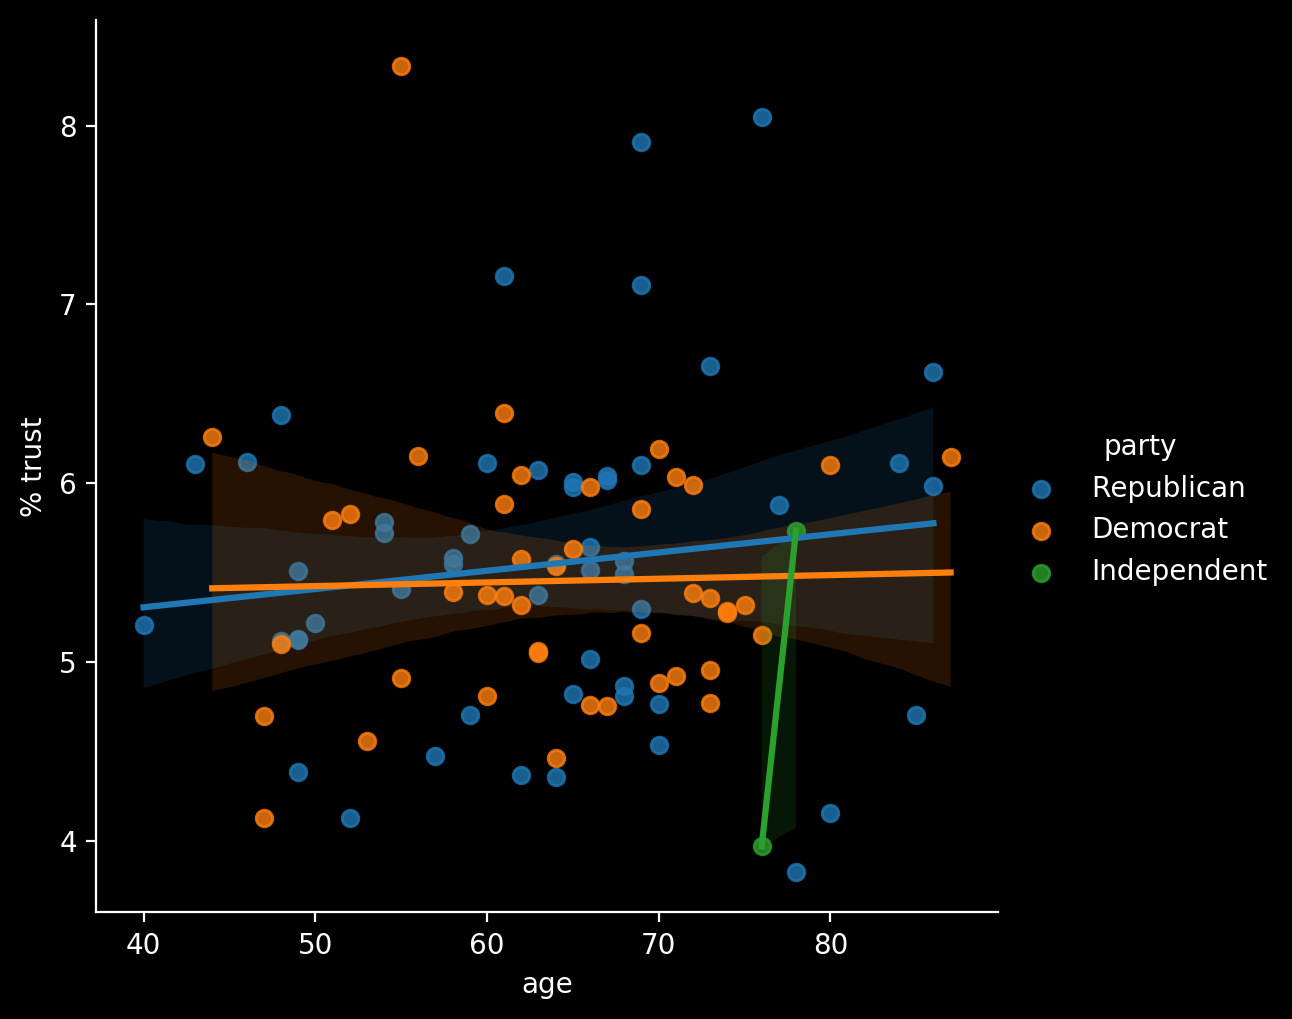

In [5]:
### ROUND THE MAX/MIN AGES TO NEAREST DECADE
sensavg['wordcount_z'] = zscore(sensavg['wordcount'])

sensavg['wordcount_z_bin'] = pd.cut(sensavg['wordcount_z'], np.arange(-2,4,step=1))
sensavg['age_bin'] = pd.cut(sensavg['age'], np.arange(40,90,step=10))
g = sns.lmplot(
    data=sensavg,
    x='age',
    y='% trust',
    hue='party')

(0, 15)

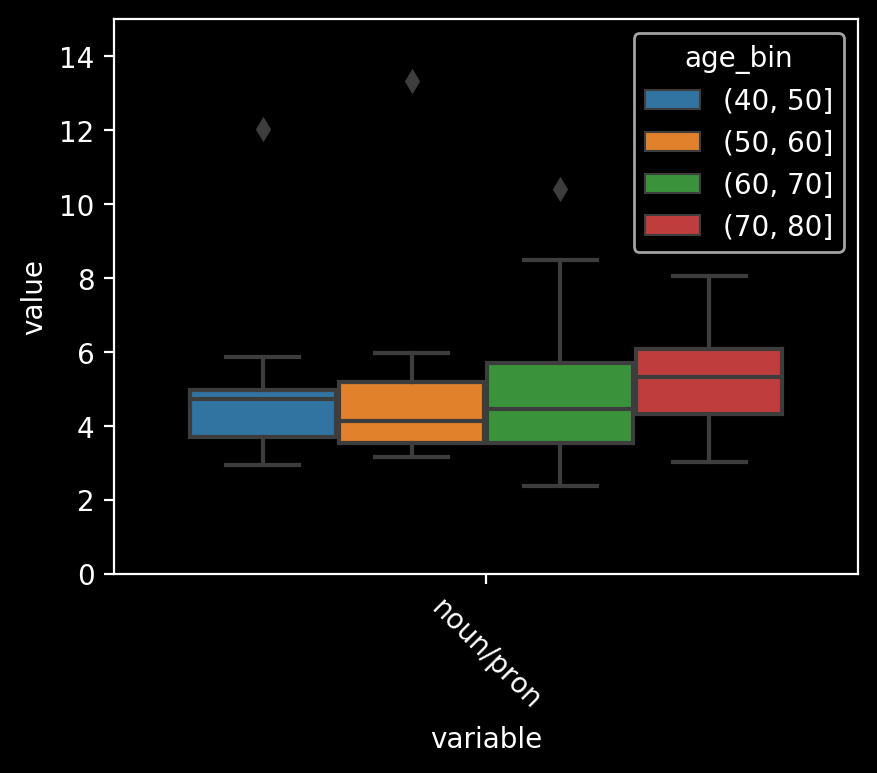

In [39]:
# s = sns.swarmplot(
#     x=sensavg['% disgust'],
#     y=sensavg['party'],
#     hue=sensavg['gender'])
emot_perc = ['% '+x for x in emot_all]
w=[['noun/pron'],['party','gender','age_bin']]

emotions = sensavg[[val for sublist in w for val in sublist]]
ax = sns.boxplot(data=emotions.melt(id_vars=['party','age_bin','gender']),x='variable',y='value',hue='age_bin')
plt.xticks(rotation=-45)
plt.ylim(0,15)

In [29]:
sensavg.sort_values(by='noun/pron',ascending=False)

,age,gender,sents,wordcount,noun,verb,adj,adv,intj,pron,wh,conj,prep,short sent,long sent,short word,long word,frag,# diff,% func words,selfish,# unique,% unique no func,% joy,% surprise,% anticipation,% anger,% fear,% trust,% disgust,% sadness,loc fear,glb fear,loc joy,glb joy,loc trust,glb trust,loc surprise,glb surprise,loc disgust,glb disgust,loc anticipation,glb anticipation,loc anger,glb anger,loc sadness,glb sadness,loc valence,glb valence,loc arousal,glb arousal,loc dominance,glb dominance,loc humor,glb humor,loc humor M,glb humor M,loc humor F,glb humor F,loc humor young,glb humor young,loc humor old,glb humor old,% humor,% VAD,short/long,words/sent,conj/sent,verb/noun,noun/pron,% diff w/func,% unique w/func,misc words,% frag,party,wordcount_z,wordcount_z_bin,age_bin
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
43,59.0,Male,28.777778,690.944444,36.428219,10.123458,6.309270,3.307361,0.644317,2.733685,0.788614,3.346071,12.125532,2.944444,25.833333,517.888889,173.055556,1.388889,234.000000,41.925622,0.137583,144.722222,29.421857,1.913829,1.192090,1.843072,0.553882,1.171158,4.700808,0.300275,0.970784,0.186820,0.005220,0.344891,0.008485,0.486438,0.023117,0.282712,0.004199,0.170070,0.001332,0.397838,0.009305,0.165904,0.002361,0.193144,0.004154,0.552396,0.159672,0.418046,0.119420,0.633071,0.174471,2.177343,0.210708,2.204149,0.213904,2.158269,0.208746,2.190875,0.210166,2.194532,0.212991,9.877699,28.194498,0.430912,19.712742,0.721065,0.346927,inf,51.142834,36.086962,615.137918,24.063093,Republican,-0.870566,"(-1.0, 0.0]","(50, 60]"
95,55.0,Male,70.629630,1372.185185,25.712156,17.216951,6.350599,5.338545,0.026411,8.166642,1.968041,3.577964,15.094805,12.518519,58.111111,1081.074074,291.111111,2.740741,448.740741,55.026957,0.429463,275.074074,21.672163,3.029233,1.345235,2.827474,1.207244,1.613303,5.405734,0.565330,1.362018,0.374110,0.007361,0.431498,0.013168,0.527938,0.028870,0.301478,0.003821,0.311365,0.002037,0.501550,0.014195,0.365534,0.004440,0.372591,0.004794,0.628402,0.195820,0.440887,0.137295,0.588891,0.183421,2.146181,0.304007,2.161963,0.305776,2.138785,0.303256,2.121627,0.300641,2.179333,0.308683,14.135260,31.186388,inf,18.871419,0.241410,0.706986,inf,41.846648,27.682579,1288.733070,10.481382,Republican,0.892879,"(0.0, 1.0]","(50, 60]"
28,78.0,Male,39.285714,724.142857,28.671550,14.333907,6.379879,3.542533,0.056100,3.563292,0.976511,3.864959,13.429270,7.714286,31.571429,533.000000,191.142857,2.714286,311.285714,43.273744,0.063212,203.714286,36.539042,2.444531,0.745774,1.573967,1.366981,1.962571,3.824739,0.311105,1.153599,0.390871,0.009133,0.349072,0.009742,0.424124,0.019164,0.217202,0.002359,0.234587,0.001274,0.419117,0.007738,0.337901,0.005667,0.363506,0.005822,0.607546,0.179306,0.466875,0.139016,0.570698,0.171303,2.105633,0.263144,2.135034,0.267442,2.082436,0.260019,2.113112,0.262476,2.107222,0.264671,12.351971,29.417371,inf,25.149524,1.560116,0.504101,inf,57.544128,44.724810,649.324857,33.707784,Republican,-0.784630,"(-1.0, 0.0]","(70, 80]"
81,66.0,Male,43.275862,1026.379310,30.655883,15.708105,6.165587,3.521325,0.006463,6.677900,1.549075,4.166109,15.965368,3.206897,40.068966,757.413793,268.965517,1.620690,386.448276,50.778242,0.461725,249.137931,25.312155,2.224123,0.609693,2.426478,1.016672,1.521932,5.642019,0.465354,1.111662,0.379902,0.007198,0.361164,0.009171,0.500577,0.029180,0.283313,0.002037,0.275480,0.001564,0.455640,0.011798,0.319876,0.004198,0.398813,0.005390,0.620499,0.212622,0.447214,0.153372,0.601469,0.206372,2.099487,0.267598,2.105163,0.268753,2.092550,0.266342,2.054117,0.263097,2.141042,0.272323,12.722969,34.258252,inf,23.088259,0.308269,0.539398,inf,45.931429,32.817680,941.963497,13.912560,Republican,-0.002267,"(-1.0, 0.0]","(60, 70]"
60,49.0,Male,51.370370,963.074074,28.544098,17.698800,6.177705,4.534355,0.062842,5.981321,1.925419,3.904943,14.424808,8.629630,42.740741,739.777778,223.296296,3.000000,347.962963,51.067566,0.263336,218.222222,25.832772,2.565819,0.949945,

In [ ]:
femmes = sensavg[sensavg['gender']=='Female']
hommes = sensavg[sensavg['gender']=='Male']
sns.violinplot(x=sensavg['party'],y=sensavg['% disgust'], split=True, hue=sensavg['gender']) 
plt.xticks(rotation=-45)